In [17]:
# 1.Analyse descriptive du dataset


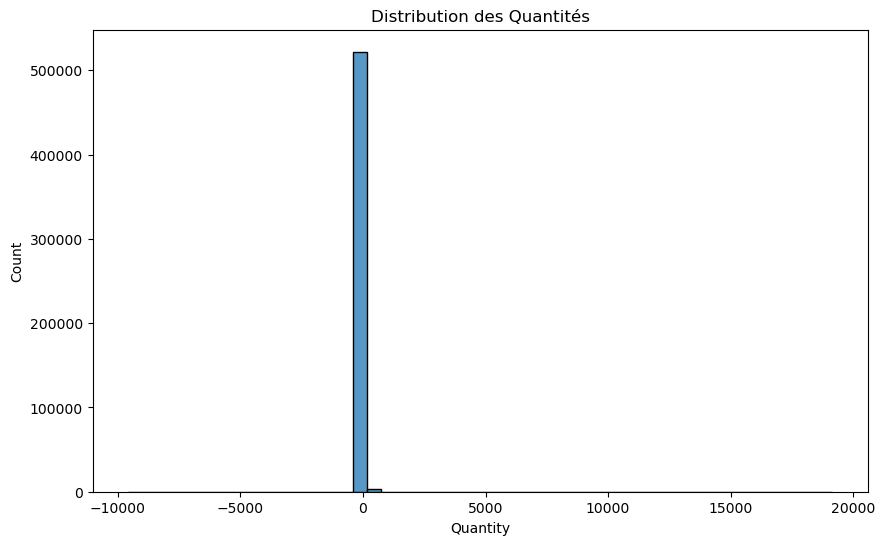

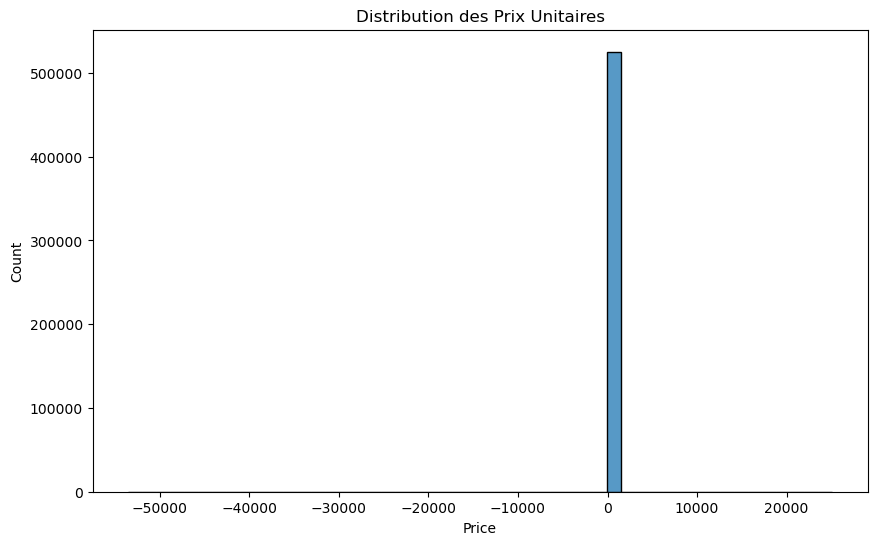

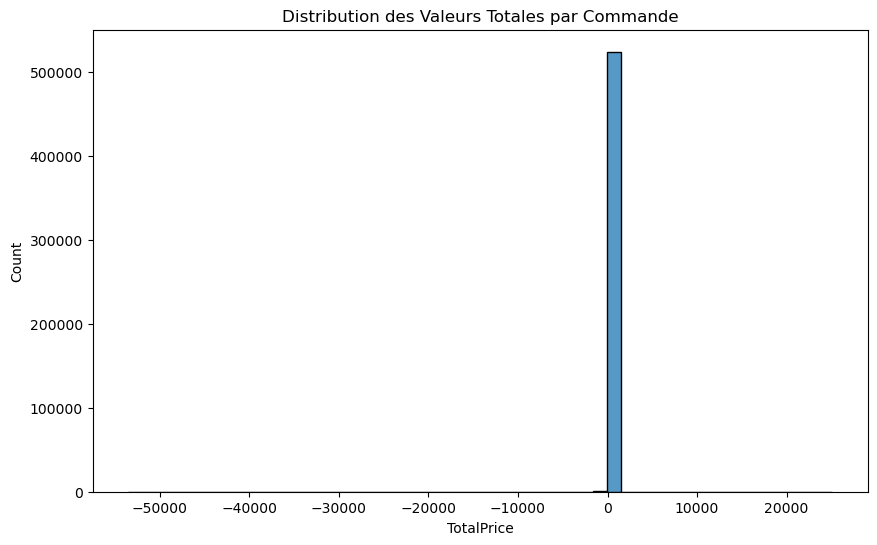

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des données
df = pd.read_excel('online_retail_II.xlsx')
# Aperçu du dataset
df.head()

##. Distribution des Quantités, Prix Unitaires et Valeurs Totales
# Ajout d'une colonne 'TotalPrice'
df['TotalPrice'] = df['Quantity'] * df['Price']

# Distribution des Quantités
plt.figure(figsize=(10,6))
sns.histplot(df['Quantity'], bins=50, kde=False)
plt.title('Distribution des Quantités')
plt.show()

# Distribution des Prix Unitaires
plt.figure(figsize=(10,6))
sns.histplot(df['Price'], bins=50, kde=False)
plt.title('Distribution des Prix Unitaires')
plt.show()

# Distribution des Valeurs Totales par commande
plt.figure(figsize=(10,6))
sns.histplot(df['TotalPrice'], bins=50, kde=False)
plt.title('Distribution des Valeurs Totales par Commande')
plt.show()

In [22]:
## Identification des Anomalies
# Identification des factures annulées (quantité négative)
annulees = df[df['Quantity'] < 0]
print(f"Nombre de factures annulées : {len(annulees)}")

# Transactions sans identifiants clients
sans_identifiant = df[df['Customer ID'].isnull()]
print(f"Nombre de transactions sans identifiants clients : {len(sans_identifiant)}")

# Affichage des commandes inhabituelles (Valeurs Totales > 95e percentile)
seuil = df['TotalPrice'].quantile(0.95)
commandes_inhabituelles = df[df['TotalPrice'] > seuil]
print(f"Nombre de commandes inhabituelles : {len(commandes_inhabituelles)}")

Nombre de factures annulées : 12326
Nombre de transactions sans identifiants clients : 107927
Nombre de commandes inhabituelles : 26228


In [26]:
## Calcul des Indicateurs RFM
# Date de la dernière transaction
current_date = df['InvoiceDate'].max()

# Récence
df_recency = df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (current_date - x.max()).days})
df_recency.columns = ['Recency']

# Fréquence
df_frequency = df.groupby('Customer ID')['InvoiceDate'].nunique()
df_frequency = pd.DataFrame(df_frequency)
df_frequency.columns = ['Frequency']

# Montant total dépensé (Monetary)
df_monetary = df.groupby('Customer ID')['TotalPrice'].sum()
df_monetary = pd.DataFrame(df_monetary)
df_monetary.columns = ['Monetary']

# Combinaison des trois indicateurs
df_rfm = pd.concat([df_recency, df_frequency, df_monetary], axis=1)
df_rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,66,15,-64.68
12347.0,2,2,1323.32
12348.0,73,1,222.16
12349.0,42,4,2646.99
12351.0,10,1,300.93


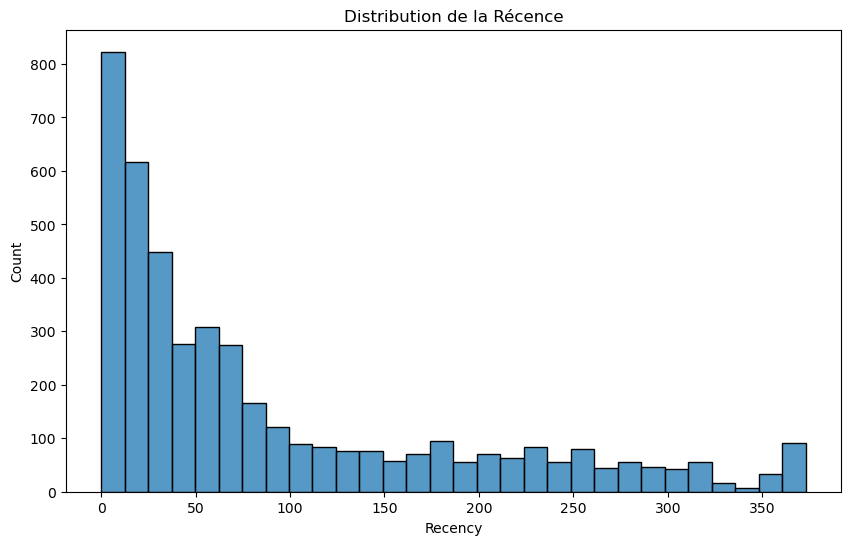

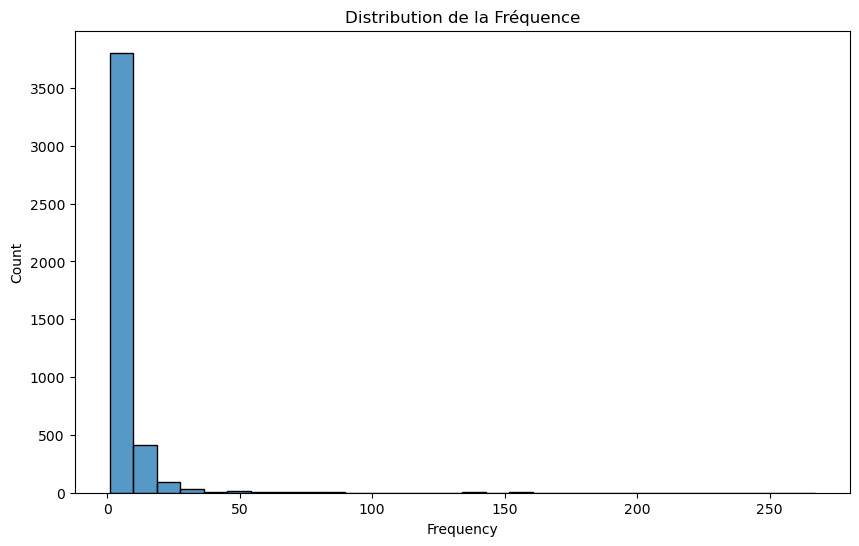

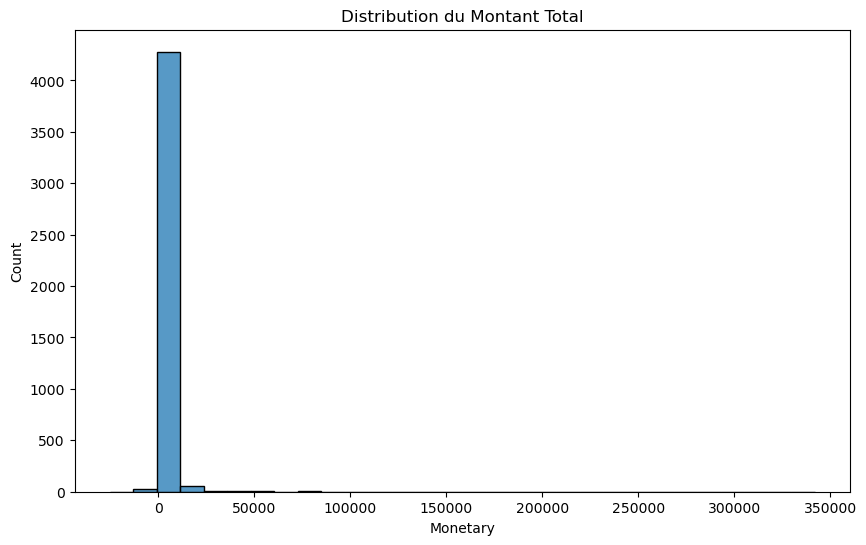

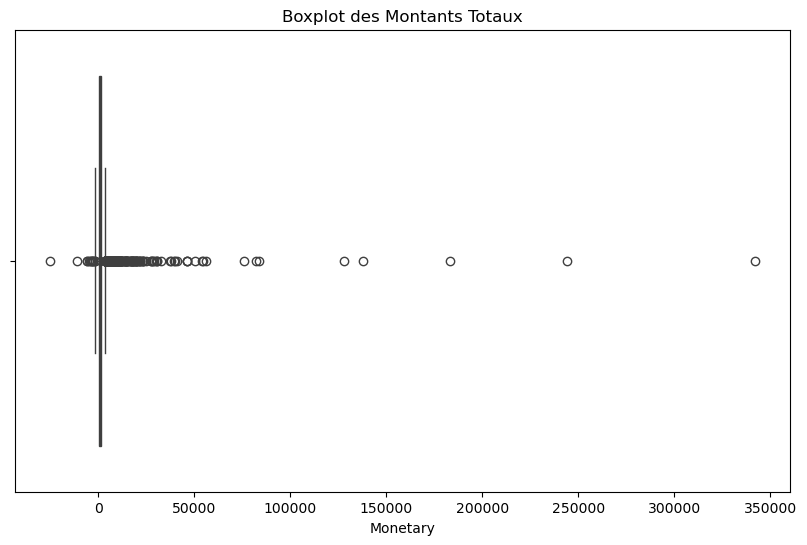

In [28]:
## Visualisation des résultats (Histogrammes et Boxplots)
# Histogramme de la Récence
plt.figure(figsize=(10,6))
sns.histplot(df_rfm['Recency'], bins=30, kde=False)
plt.title('Distribution de la Récence')
plt.show()

# Histogramme de la Fréquence
plt.figure(figsize=(10,6))
sns.histplot(df_rfm['Frequency'], bins=30, kde=False)
plt.title('Distribution de la Fréquence')
plt.show()

# Histogramme du Montant (Monetary)
plt.figure(figsize=(10,6))
sns.histplot(df_rfm['Monetary'], bins=30, kde=False)
plt.title('Distribution du Montant Total')
plt.show()

# Boxplot pour détecter les outliers dans Monetary
plt.figure(figsize=(10,6))
sns.boxplot(x=df_rfm['Monetary'])
plt.title('Boxplot des Montants Totaux')
plt.show()

In [ ]:
# 2.Prétraitement des données

In [30]:
## Traitement des valeurs manquantes
# Exclusion des lignes où 'Customer ID' est manquant
df_cleaned = df.dropna(subset=['Customer ID'])

# Afficher le nombre de lignes après nettoyage
print(f"Lignes restantes après suppression des valeurs manquantes: {df_cleaned.shape[0]}")


Lignes restantes après suppression des valeurs manquantes: 417534


In [32]:
## Correction des données anormales
# Exclusion des lignes avec des quantités négatives (retours ou annulations)
df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0]

# Afficher le nombre de lignes après suppression des anomalies
print(f"Lignes restantes après suppression des quantités négatives: {df_cleaned.shape[0]}")


Lignes restantes après suppression des quantités négatives: 407695


In [34]:
## Création des variables dérivées
# Ajout de la colonne 'TotalPrice' qui est le produit de 'Quantity' et 'Price'
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['Price']

# Affichage des premières lignes pour vérifier
df_cleaned[['Quantity', 'Price', 'TotalPrice']].head()


,Quantity,Price,TotalPrice
0,12,6.95,83.4
1,12,6.75,81.0
2,12,6.75,81.0
3,48,2.10,100.8
4,24,1.25,30.0


In [37]:
## Standardisation des variables
from sklearn.preprocessing import StandardScaler

# Sélection des variables RFM (Recency, Frequency, Monetary) pour la standardisation
scaler = StandardScaler()
df_rfm_scaled = scaler.fit_transform(df_rfm)

# Convertir les données standardisées en DataFrame
df_rfm_scaled = pd.DataFrame(df_rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Afficher un aperçu des données standardisées
df_rfm_scaled.head()


,Recency,Frequency,Monetary
0,-0.248511,0.968178,-0.231189
1,-0.900473,-0.337337,-0.068247
2,-0.177203,-0.437761,-0.197516
3,-0.492997,-0.136488,0.087142
4,-0.818977,-0.437761,-0.188269


In [ ]:
# 3.Segmentation des clients

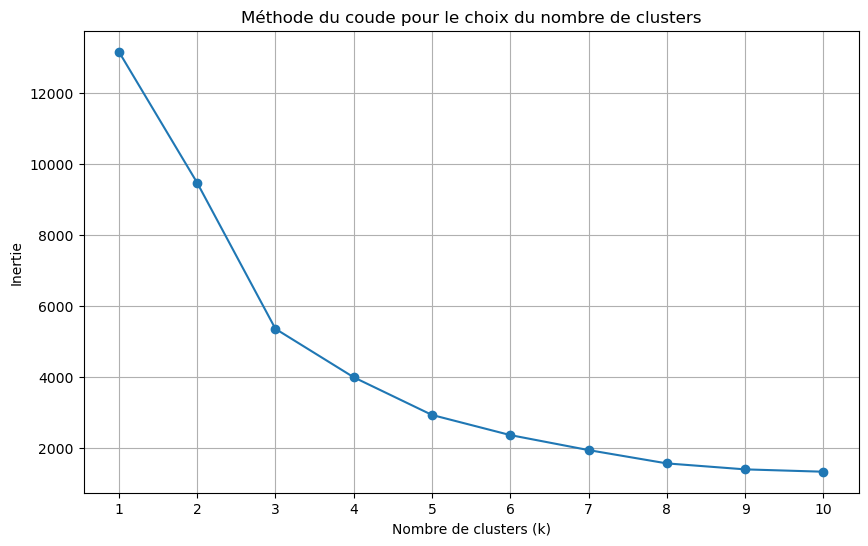

In [39]:
## Appliquer K-means pour regrouper les clients
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Déterminer le nombre optimal de clusters avec la méthode du coude
inertia = []
k_values = range(1, 11)  # Essayer de 1 à 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_rfm_scaled)
    inertia.append(kmeans.inertia_)

# Tracer la courbe du coude
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Méthode du coude pour le choix du nombre de clusters')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.xticks(k_values)
plt.grid()
plt.show()

In [41]:
## Application du modèle K-means
# Appliquer K-means avec le nombre optimal de clusters (par exemple, 4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_rfm['Cluster'] = kmeans.fit_predict(df_rfm_scaled)

# Afficher la répartition des clients par cluster
cluster_counts = df_rfm['Cluster'].value_counts()
print("Répartition des clients par cluster :")
print(cluster_counts)


Répartition des clients par cluster :
Cluster
0    3182
1    1072
3     120
2       9
Name: count, dtype: int64


In [43]:
## Tester DBSCAN pour la segmentation
from sklearn.cluster import DBSCAN

# Appliquer DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_rfm['DBSCAN_Cluster'] = dbscan.fit_predict(df_rfm_scaled)

# Compter le nombre de points dans chaque cluster
dbscan_counts = df_rfm['DBSCAN_Cluster'].value_counts()
print("Répartition des clients par cluster DBSCAN :")
print(dbscan_counts)


Répartition des clients par cluster DBSCAN :
DBSCAN_Cluster
 0    4313
-1      63
 1       7
Name: count, dtype: int64


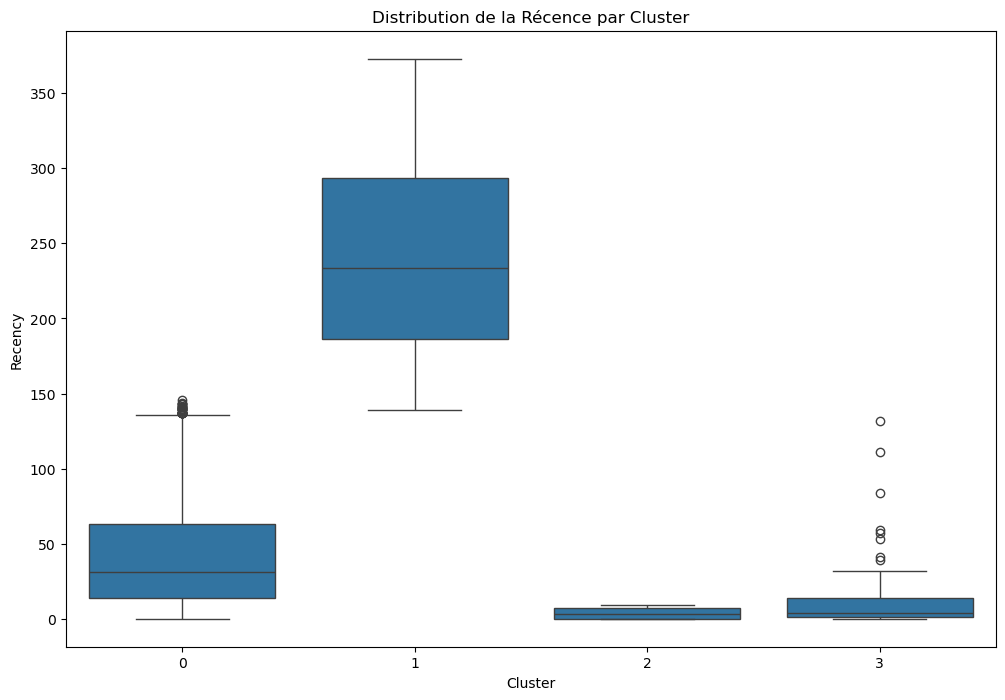

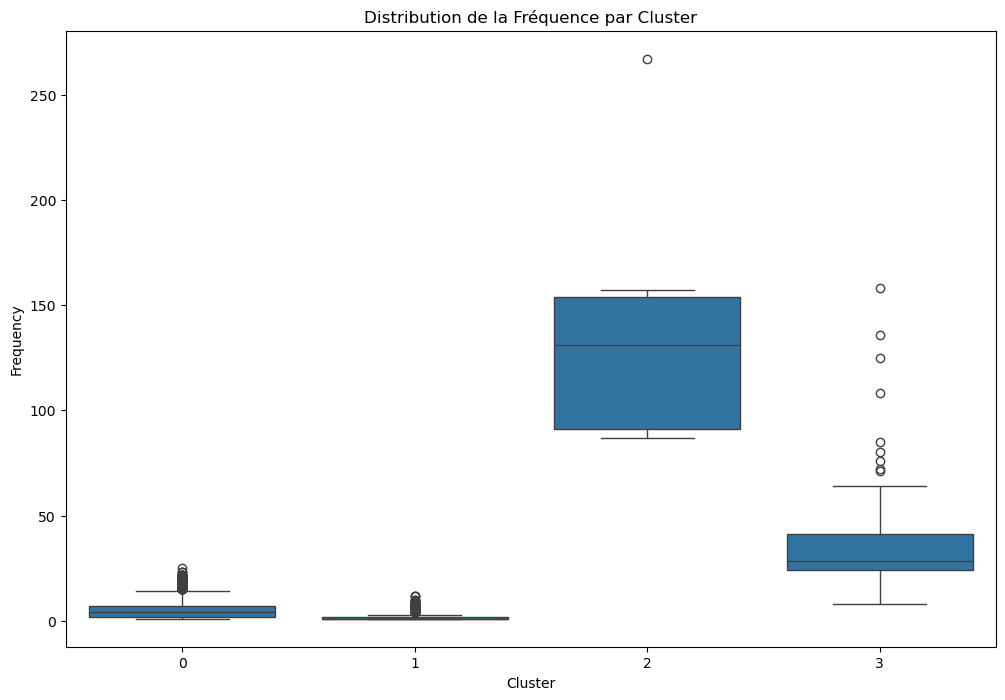

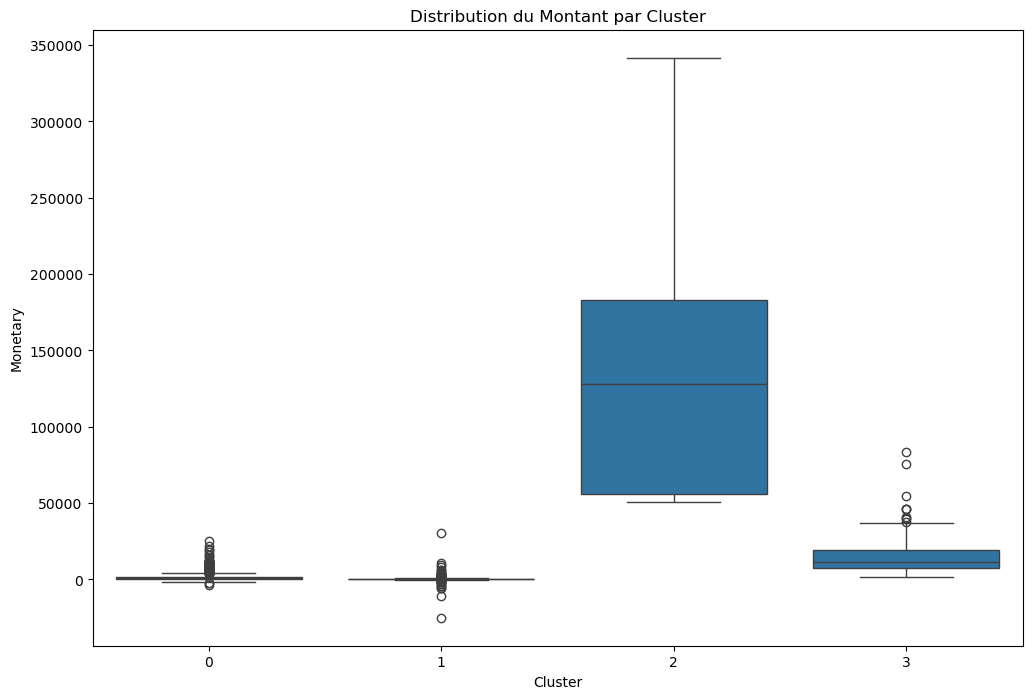

In [45]:
## Analyse RFM
import seaborn as sns

# Visualisation des segments RFM
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_rfm, x='Cluster', y='Recency')
plt.title('Distribution de la Récence par Cluster')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_rfm, x='Cluster', y='Frequency')
plt.title('Distribution de la Fréquence par Cluster')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_rfm, x='Cluster', y='Monetary')
plt.title('Distribution du Montant par Cluster')
plt.show()


In [ ]:
# 4.Optimisation des hyperparamètres

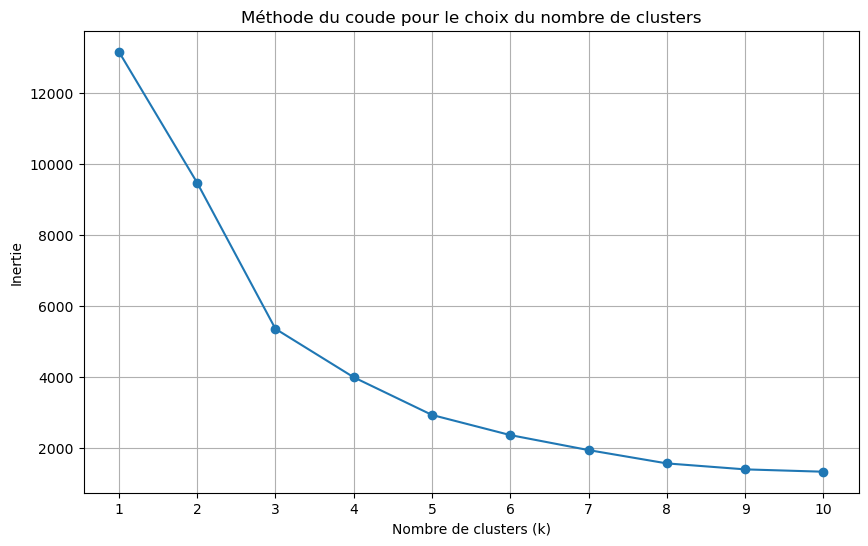

In [47]:
## Utiliser la méthode du coude
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Déterminer le nombre optimal de clusters avec la méthode du coude
inertia = []
k_values = range(1, 11)  # Essayer de 1 à 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_rfm_scaled)
    inertia.append(kmeans.inertia_)

# Tracer la courbe du coude
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Méthode du coude pour le choix du nombre de clusters')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.xticks(k_values)
plt.grid()
plt.show()


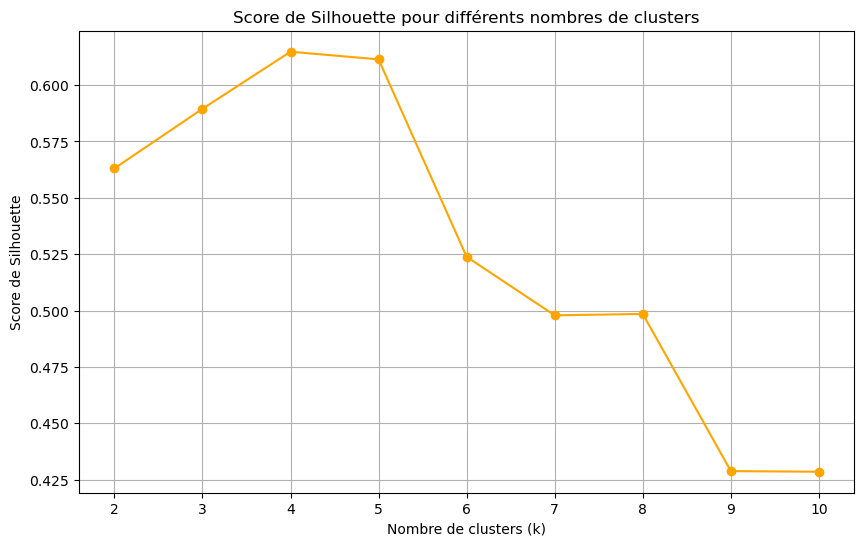

In [49]:
## Calculer le score de silhouette
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in k_values[1:]:  # Commencer à 2 car le score de silhouette n'est pas défini pour k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_rfm_scaled)
    score = silhouette_score(df_rfm_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Tracer le score de silhouette
plt.figure(figsize=(10, 6))
plt.plot(k_values[1:], silhouette_scores, marker='o', color='orange')
plt.title('Score de Silhouette pour différents nombres de clusters')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de Silhouette')
plt.xticks(k_values[1:])
plt.grid()
plt.show()


In [51]:
## Ajustement des paramètres de clustering 
# Appliquer K-means avec le nombre optimal de clusters (par exemple, 4)
optimal_k = 4  # à remplacer par le nombre optimal trouvé
kmeans = KMeans(n_clusters=optimal_k, random_state=42, init='k-means++', n_init=10, max_iter=300)
df_rfm['Cluster'] = kmeans.fit_predict(df_rfm_scaled)

# Afficher les résultats
print(f"Centres des clusters : \n{kmeans.cluster_centers_}")
print("Répartition des clients par cluster :")
print(df_rfm['Cluster'].value_counts())


Centres des clusters : 
[[-8.07699116e-01  5.28283365e+00  2.96182996e+00]
 [ 1.56026537e+00 -3.47145383e-01 -1.75801082e-01]
 [-5.01288631e-01  3.36977467e-03 -2.99414818e-02]
 [-8.73986728e-01  1.32801887e+01  2.40687355e+01]]
Répartition des clients par cluster :
Cluster
2    3247
1    1075
0      56
3       5
Name: count, dtype: int64


In [ ]:
# 5.Visualisation et Interprétation des résultats

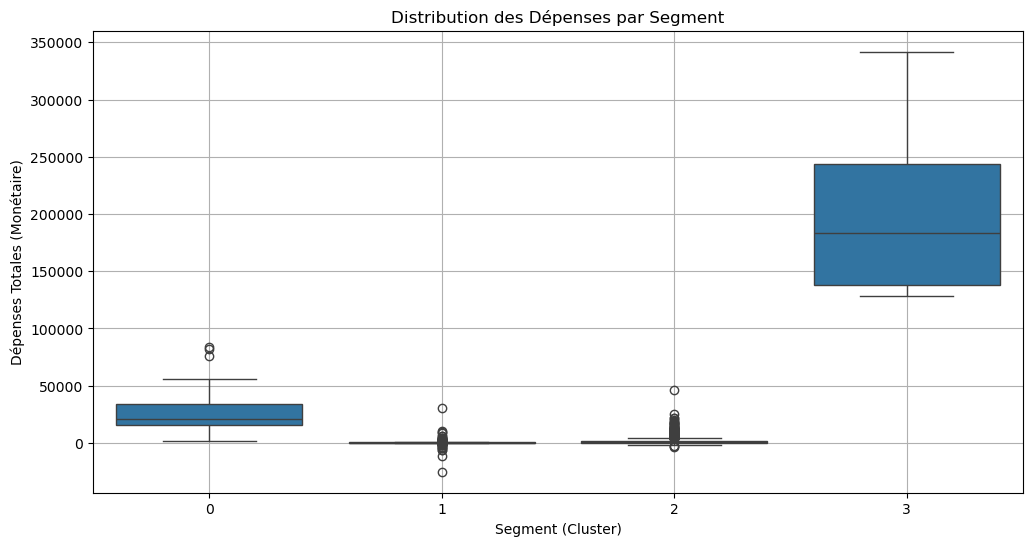

In [53]:
## Visualisation avec des boîtes à moustache
import seaborn as sns

# Visualiser la distribution des dépenses par segment
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Monetary', data=df_rfm)
plt.title('Distribution des Dépenses par Segment')
plt.xlabel('Segment (Cluster)')
plt.ylabel('Dépenses Totales (Monétaire)')
plt.grid()
plt.show()


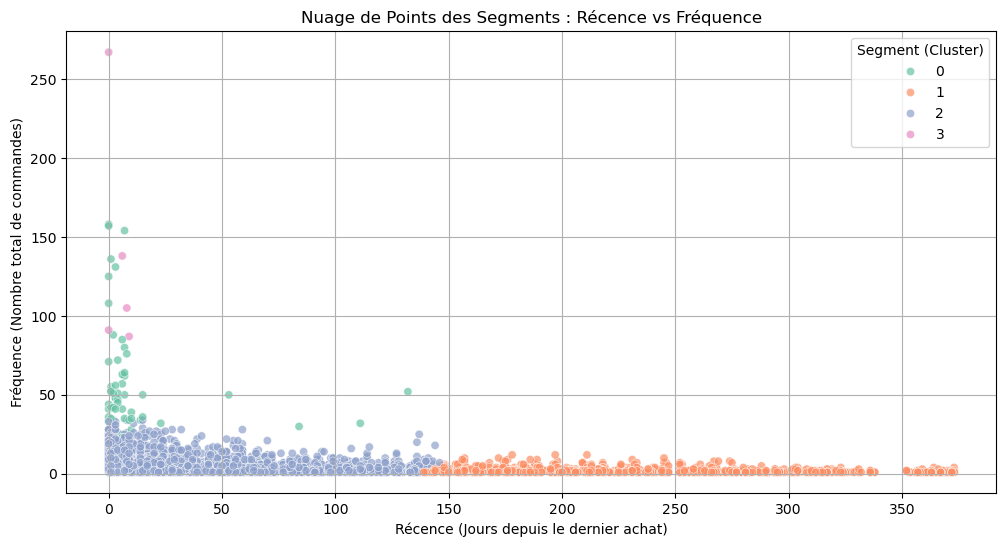

In [55]:
## Comparaison des clusters avec des diagrammes en nuage de points
# Comparer les clusters avec un nuage de points
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=df_rfm, palette='Set2', alpha=0.7)
plt.title('Nuage de Points des Segments : Récence vs Fréquence')
plt.xlabel('Récence (Jours depuis le dernier achat)')
plt.ylabel('Fréquence (Nombre total de commandes)')
plt.legend(title='Segment (Cluster)')
plt.grid()
plt.show()


In [83]:
## Analyse des valeurs atypiques
# Calcul des clusters avec K-means
df_rfm['Cluster'] = kmeans.fit_predict(df_rfm[['Recency', 'Frequency', 'Monetary']])

# Vérifiez que la colonne 'Customer ID' est dans df_rfm
print(df_rfm.columns)

# Maintenant, vous pouvez ajouter 'Cluster' à df_rfm à partir d'une autre source si nécessaire
# Assurez-vous que la colonne 'Customer ID' existe dans df_rfm
df_rfm = df_rfm.merge(df[['Customer ID']], on='Customer ID', how='left')

# Vous pouvez continuer avec votre analyse des valeurs atypiques
for cluster in df_rfm['Cluster'].unique():
    atypical_clients = df_rfm[(df_rfm['Cluster'] == cluster) & (df_rfm['Monetary'] > df_rfm['Monetary'].quantile(0.95))]
    print(f"\nClients atypiques dans le Cluster {cluster} :")
    print(atypical_clients[['Customer ID', 'Monetary', 'Recency', 'Frequency', 'Cluster']])


Index(['Recency', 'Frequency', 'Monetary', 'Cluster', 'DBSCAN_Cluster'], dtype='object')

Clients atypiques dans le Cluster 0 :
Empty DataFrame
Columns: [Customer ID, Monetary, Recency, Frequency, Cluster]
Index: []

Clients atypiques dans le Cluster 2 :
        Customer ID  Monetary  Recency  Frequency  Cluster
47107       13089.0  55828.31        3        131        2
47108       13089.0  55828.31        3        131        2
47109       13089.0  55828.31        3        131        2
47110       13089.0  55828.31        3        131        2
47111       13089.0  55828.31        3        131        2
...             ...       ...      ...        ...      ...
392112      17850.0  50414.50        7        154        2
392113      17850.0  50414.50        7        154        2
392114      17850.0  50414.50        7        154        2
392115      17850.0  50414.50        7        154        2
392116      17850.0  50414.50        7        154        2

[8601 rows x 5 columns]

Clients aty